In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from folium.plugins import HeatMap

In [69]:
# dataset 2 - alternative fuel stations
columns_to_keep = ['State', 'Latitude', 'Longitude', 'Open Date']

stations = pd.read_csv('data/alt_fuel_stations (Dec 2 2023).csv', usecols=columns_to_keep, engine='python')

stations['Open Date'] = pd.to_datetime(stations['Open Date'], format='%Y-%m-%d')

In [70]:
# dataset 3 - USA
usa = pd.read_csv('data/usa.csv')

columns_to_int = ['Population', 'Land_area']
usa[columns_to_int] = usa[columns_to_int].replace({',': ''}, regex=True).apply(pd.to_numeric)

/var/folders/1n/76f51gz14z3d8jfl34xk49zw0000gn/T/ipykernel_77929/3319931624.py:26: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  s20 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2020, 1, 1)]
/var/folders/1n/76f51gz14z3d8jfl34xk49zw0000gn/T/ipykernel_77929/3319931624.py:27: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  s23 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2023, 1, 1)]


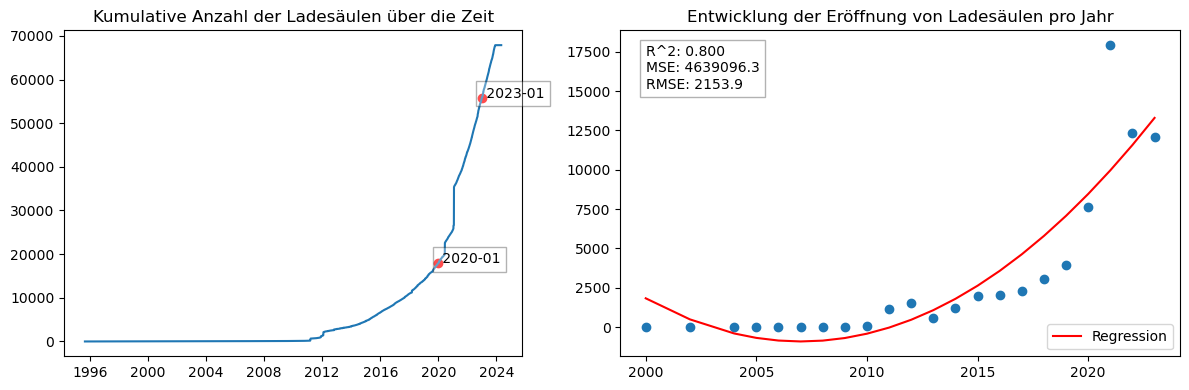

In [71]:
# Wie hat sich die Anzahl der Ladesäulen im Laufe der Zeit entwickelt
# Gibt es einen Trend in der Eröffnung von Ladesäulen über die Jahre?
stations_dev = stations.groupby(stations['Open Date'].dt.date).size().cumsum().reset_index(name='Count')

stations_trend = stations.groupby(stations['Open Date'].dt.year).size().reset_index(name='Count')
# erst ab 2000, davor zu gering
# es gibt eine Station 2024 im Datensatz
stations_trend = stations_trend[stations_trend['Open Date'] >= 2000]
stations_trend = stations_trend[stations_trend['Open Date'] != 2024]

x = stations_trend['Open Date']
y = stations_trend['Count']

# Quadratische Regression (Polynomgrad 2)
coefficients = np.polyfit(x, y, 2)

# Erzeugung einer quadratischen Funktion mit den berechneten Koeffizienten
quadratic_function = np.poly1d(coefficients)

# Vorhersage für Werte in x
predicted_y = quadratic_function(x)

r_2 = r2_score(y, predicted_y)
mse = np.mean((y - predicted_y)**2)

s20 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2020, 1, 1)]
s23 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2023, 1, 1)]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [4.5, 5.5]})

axs[0].set_title('Kumulative Anzahl der Ladesäulen über die Zeit')
axs[0].plot(stations_dev['Open Date'], stations_dev['Count'], linestyle='-', label='Linie')
axs[0].scatter([s20.values[0][0], s23.values[0][0]], [s20.values[0][1], s23.values[0][1]], color='red')
axs[0].text(s20.values[0][0], s20.values[0][1], ' 2020-01', bbox=dict(facecolor='white', alpha=0.3))
axs[0].text(s23.values[0][0], s23.values[0][1], ' 2023-01', bbox=dict(facecolor='white', alpha=0.3))

axs[1].set_title('Entwicklung der Eröffnung von Ladesäulen pro Jahr')
axs[1].scatter(x, y)
axs[1].plot(x, predicted_y, label='Regression', color='red')
axs[1].text(min(x), max(y), f'R^2: {r2_score(y, predicted_y):.3f}\nMSE: {mse:.1f}\nRMSE: {np.sqrt(mse):.1f}', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.3))
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

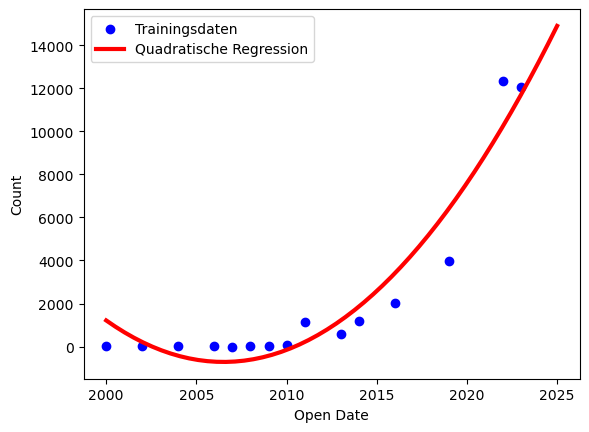

In [72]:
# Input-Variable
x_reg = stations_trend['Open Date']
# Quadratischer Term hinzufügen
x_reg_sq = x_reg ** 2
# Input-Matrix erstellen (linearer Term und quadratischer Term)
X_reg = np.column_stack((x_reg, x_reg_sq))

# Output-Variable
y_reg = stations_trend['Count']

# Aufteilen in Test- und Trainingsdatensatz
x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=1)

# Lernen des Modells
regressor = LinearRegression()
regressor.fit(x_reg_train, y_reg_train)

# Plot für Trainingsdaten
x_input = np.linspace(min(x_reg_train[:, 0]), 2025).reshape(-1, 1)
x_input_sq = x_input ** 2
X_input = np.column_stack((x_input, x_input_sq))
y_input = regressor.predict(X_input)

plt.scatter(x_reg_train[:, 0], y_reg_train, color='blue', label='Trainingsdaten')
plt.plot(x_input, y_input, color='red', linewidth=3, label='Quadratische Regression')
plt.xlabel('Open Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Trainingsfehler R^2 und MSE
y_reg_train_pred = regressor.predict(x_reg_train)

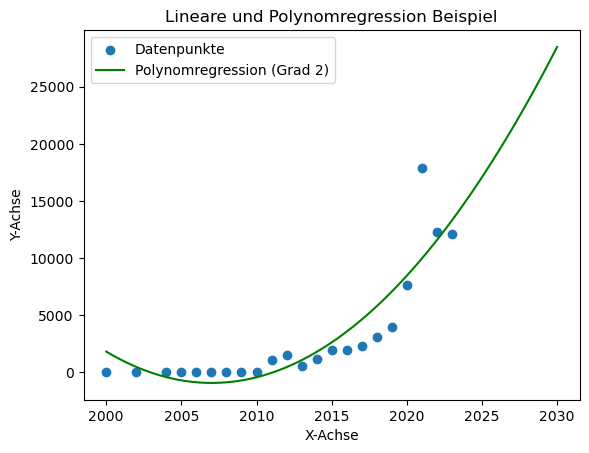

In [83]:
# Beispiel-Daten
x = np.array(stations_trend['Open Date'])
y = np.array(stations_trend['Count'])

# Lineare Regression
regressor = LinearRegression()

# Aufteilen in Test- und Trainingsdatensatz
x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(x.reshape(-1, 1), y, test_size=0.3, random_state=1)

# Lernen des Modells
regressor.fit(x_reg_train, y_reg_train.reshape(-1, 1))

# Vorhersage auf Trainingsdaten
y_reg_train_pred = regressor.predict(x_reg_train)

# Polynomregression
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Neue x-Werte für die Kurve
x_curve = np.linspace(min(x), 2030, 100)

# Berechnung der y-Werte für die Kurve
y_curve = polynomial(x_curve)

# Plot der Daten, der linearen Regression und der Polynomregression
plt.scatter(x, y, label='Datenpunkte')
plt.plot(x_curve, y_curve, label='Polynomregression (Grad 2)', color='green')
plt.legend()
plt.xlabel('X-Achse')
plt.ylabel('Y-Achse')
plt.title('Lineare und Polynomregression Beispiel')
plt.show()